<a href="https://colab.research.google.com/github/erikyryan/document-classification/blob/main/document_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pré-processamento dos dados

Foram realizadas várias etapas de pré-processamento para garantir que os dados estivessem no formato correto. Primeiro, foi lida a base de dados e filtrados os arquivos pelo tipo desejado. Em seguida, foi alterado o tamanho das imagens para garantir que elas fossem compatíveis com os modelos. Por fim, foram preparados os dados para execução nos modelos.



## Import das funções

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import random
import requests
import os
import zipfile
import glob
import cv2
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from random import randint

from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split

A função `process_images` filtra os arquivos permitindo que sejam selecionados somente os arquivos corretos para análise. A função recebe como parâmetro o filepath, que é o diretório do arquivo, e também o parâmetro size, contendo o formato das imagens desejado e um parâmetro para determinar a quantidade máxima de imagens que se deseja ter, tendo como padrão o valor de 3500. Isso pode variar conforme o que for informado.

In [97]:
def process_images(filepath, size, max_files=3500):
    filenames = []
    readed_imgs = []
    resized_imgs = []
    i = 0

    # Read file paths
    for filename in glob.glob(filepath):
        if ('segmentation' not in filename) and filename.endswith('.jpg') and i < max_files:
            filenames.append(filename)
            i += 1
        else:
            os.remove(filename)

    for img in filenames:
        readed_imgs.append(cv2.imread(img))

    for img in readed_imgs:
        resized_imgs.append(cv2.resize(img, size))

    return resized_imgs

#define os resultados para cada label
def result(test):
	if test == 1 or test == 2 or test == 3:
		return 'CNH'
	elif test == 4 or test == 5:
		return 'CPF'
	elif test == 7 or test == 6 or test == 8:
		return 'RG'
	else: return None

## Download e Extração das imagens de treinamento

In [98]:
pathSample = 'https://drive.google.com/uc?id=144EqqmMtCziua9iYo-3afUEvZrJVxUXU&export=download&confirm=t&uuid=363cbdc1-ef8d-40e3-ac8f-92e8efbac4de&at=AKKF8vwO3Rerxp4Y4e7nvK22YqGB:1687737101639' #Database Sample
compressionSamplePath = '/content/storage/sample.zip'
sourcePath = '/content/storage'

if not(os.path.isdir(sourcePath)):
  os.mkdir('storage') #diretorio para armazenar os arquivos baixados.

In [99]:
response = requests.post(pathSample)

with open(compressionSamplePath, 'wb') as file:
    file.write(response.content)

with zipfile.ZipFile(compressionSamplePath, 'r') as zip_ref:
    zip_ref.extractall(sourcePath)


## Formatação dos documentos

Realizando a chamada para cada grupo de imagem e formatado com o tamanho apropriedado

In [100]:
cnh_aberta =  process_images(sourcePath +'/BID Sample Dataset/CNH_Aberta/*', (256,256))
cnh_frente =  process_images(sourcePath +'/BID Sample Dataset/CNH_Frente/*', (256,256))
cnh_verso =  process_images(sourcePath +'/BID Sample Dataset/CNH_Verso/*', (256,256))

cpf_frente =  process_images(sourcePath +'/BID Sample Dataset/CPF_Frente/*', (256,256))
cpf_verso =  process_images(sourcePath +'/BID Sample Dataset/CPF_Verso/*', (256,256))

rg_frente =  process_images(sourcePath +'/BID Sample Dataset/RG_Frente/*', (256,256))
rg_verso =  process_images(sourcePath +'/BID Sample Dataset/RG_Verso/*', (256,256))
rg_aberto =  process_images(sourcePath +'/BID Sample Dataset/RG_Aberto/*', (256,256))

## Preparação dos dados para o treinamento

Nesta criamos uma list de dicionarios, devido o uso da funcao zip, ao finalizar garante que permanecera com um numero exato de documentos, para caso os arrays tenham tamanho diferente. Assim, facilitando a uniao de ambos.

In [101]:
labels = [1,2,3,4,5,6,7,8]
documents = []

for a,b,c,d,e,f,g,h in zip(cnh_aberta,cnh_frente,cnh_verso,cpf_frente,cpf_verso,rg_frente,rg_verso,rg_aberto):
	documents.append({'x':a,'y':labels[0]})
	documents.append({'x':b,'y':labels[1]})
	documents.append({'x':c,'y':labels[2]})
	documents.append({'x':d,'y':labels[3]})
	documents.append({'x':e,'y':labels[4]})
	documents.append({'x':f,'y':labels[5]})
	documents.append({'x':g,'y':labels[6]})
	documents.append({'x':h,'y':labels[7]})


In [102]:
x_train = []
y_train = []

x_test = []
y_test = []

np.random.shuffle(documents)

x_train = [document['x'] for document in documents[:1000]]
y_train = [document['y'] for document in documents[:1000]]

x_test = np.array([document['x'] for document in documents[:2000]])
y_test = np.array([document['y'] for document in documents[:2000]])

In [103]:
x = [document['x'] for document in documents]
y = [document['y'] for document in documents]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

x_train = np.array(x_train)
n_samples = x_train.shape[0]
x_train = x_train.reshape((n_samples, -1))

x_test = np.array(x_test)
n_samples = x_test.shape[0]
x_test = x_test.reshape((n_samples, -1))

y_test = np.array(y_test)
y_train = np.array(y_train)


# Modelo SVC

SVC é a sigla para **Support Vector Classification**, que é um tipo de **Support Vector Machine (SVM)**, um algoritmo de aprendizado de máquina supervisionado que pode ser usado para desafios de classificação ou regressão. A principal diferença entre SVM e SVC é que se o hiperplano classifica o conjunto de dados linearmente, então o algoritmo é chamado de SVC e o algoritmo que separa o conjunto de dados por abordagem não linear é chamado de SVM.


In [104]:
svc = SVC(probability=True, kernel='linear')
svc.fit(x_train, y_train)

SVC(kernel='linear', probability=True)

In [105]:
y_pred = svc.predict(x_test)
y_pred_proba = svc.predict_proba(x_test)

In [106]:
acc_svc = accuracy_score(y_test, y_pred)
loss_svc = log_loss(y_test, y_pred_proba)

In [107]:
print(f'Acurácia: {acc_svc:.2f}')
print(f'Perda Logarítmica: {loss_svc:.2f}')

Acurácia: 0.96
Perda Logarítmica: 0.28


# Rede neural convolucional

Abaixo preparamos os dados alterando novamente o tamanho das imagens para o formato determinado, para os valore de x e para y.

In [108]:
x_train = x_train.reshape(len(x_train),256, 256, 3)
x_test = x_test.reshape(len(x_test), 256, 256, 3)
y_test = y_test.reshape(len(y_test), 1)
y_train = y_train.reshape(len(y_train), 1)

## Criando um gerador de aumento de dados

A função abaixo é usada para criar instâncias de geradores de imagem com transformações aleatórias. As transformações incluem rotação, mudança de largura e altura e espelhamento horizontal. Essas transformações são aplicadas aleatoriamente às imagens de entrada durante o treinamento do modelo para aumentar a quantidade de dados disponíveis e evitar o overfitting.

In [109]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

## Construindo o modelo

 O modelo tem duas camadas convolucionais com 32 e 64 filtros, respectivamente, seguidas por camadas de pooling e dropout. A camada densa tem 128 neurônios e a camada de saída tem apenas um neurônio com ativação softmax. O modelo é compilado com a função de perda binary_crossentropy e o otimizador Adam. Ele é usado para classificar imagens em duas classes.

In [110]:
classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D((2, 2)))
classifier.add(Dropout(0.25))

classifier.add(Flatten())
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(1, activation='softmax'))

## Compilando o modelo

O código abaixo é usada para compilar o modelo. O parâmetro loss é a função de perda usada para otimizar o modelo. O parâmetro optimizer é o algoritmo de otimização usado para minimizar a função de perda. O parâmetro metrics é uma lista de métricas usadas para avaliar o desempenho do modelo durante o treinamento e teste. Nesse caso, a métrica usada é a acurácia.

In [111]:
classifier.compile( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

## Treinando a Rede Neural Convolucional

O parâmetro **batch_size** é o número de amostras usadas em cada atualização do gradiente. O parâmetro **steps_per_epoch** é o número de lotes a serem extraídos do gerador de dados em cada época. O método fit() é usado para treinar o modelo com os dados gerados pelo datagen.flow(). Nesse caso, o modelo é treinado por 5 épocas.

In [112]:
batch_size = 64
steps_per_epoch = len(x_train) // batch_size
classifier.fit(datagen.flow(x_train, y_train, batch_size=batch_size), epochs=5, steps_per_epoch=steps_per_epoch)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


3/3 [==============================] - 17s 6s/step - loss: 0.0000e+00 - accuracy: 0.1373
Epoch 2/5
3/3 [==============================] - 19s 6s/step - loss: 0.0000e+00 - accuracy: 0.1406
Epoch 3/5
3/3 [==============================] - 15s 5s/step - loss: 0.0000e+00 - accuracy: 0.1569
Epoch 4/5
3/3 [==============================] - 15s 6s/step - loss: 0.0000e+00 - accuracy: 0.1438
Epoch 5/5
3/3 [==============================] - 16s 5s/step - loss: 0.0000e+00 - accuracy: 0.1176


Esse trecho de código é usado para avaliar o desempenho do modelo em um conjunto de dados de teste. O método evaluate() é usado para avaliar o modelo com os dados de teste x_test e y_test. Ele retorna a perda e a acurácia do modelo nos dados de teste. Esses valores são impressos na tela usando o comando print().

In [124]:
loss_rnc, acc_rnc = classifier.evaluate(x_test, y_test)

2/2 [==============================] - 2s 636ms/step - loss: 0.0000e+00 - accuracy: 0.1091


In [114]:
print('SVC - Acurácia: ', acc_svc, ', Loss: ', loss_svc)
print('Rede Neural - Acurácia: ', acc_rnc, ', Loss: ', loss_rnc)

SVC - Acurácia:  0.9636363636363636 , Loss:  0.27914514120361217
Rede Neural - Acurácia:  0.1090909093618393 , Loss:  0.0


# Resultados

Os resultados apresentados mostram a acurácia e a perda de dois modelos diferentes (SVC e Rede Neural) em cinco execuções diferentes. A acurácia é a proporção de amostras classificadas corretamente pelo modelo. A perda é uma medida da qualidade do modelo, onde valores menores indicam um modelo melhor.       
    
Em geral, o modelo com alta acurácia e baixa perda é considerado um bom modelo. No entanto, é importante avaliar o desempenho do modelo em um conjunto de dados de teste para obter uma estimativa precisa do desempenho do modelo.

Para os casos mostrados abaixo, o SVC apresentou um otimo desempenho, mesmo usando um volume baixo de dados, os dados evidenciam que foi possivel obter uma boa acuracia, proximo a 1, enquanto para a Rede neural, houve uma diferenca signifcativa, que pode ter se dado devido a ter apenas usado valores de testes e devido a ter um conjunto baixo de dados e por haver menos camadas no modelo.  
  
Por fim, a perda da Rede Neural foi minima ou quase nula, por isso o valor sendo zero em todos os testes.Como

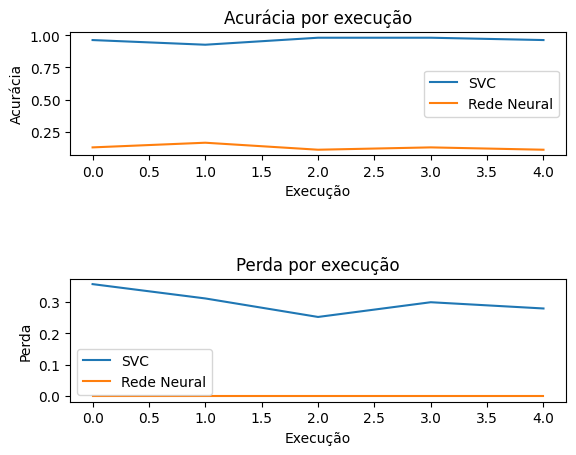

In [122]:

import matplotlib.pyplot as plt

# Dados de exemplo
acuracia_svc = [0.9636363636363636, 0.9272727272727272, 0.9818181818181818, 0.9818181818181818, 0.9636363636363636]
acuracia_rede_neural = [0.12727272510528564, 0.16363635659217834, 0.1090909093618393, 0.12727272510528564, 0.1090909093618393]
loss_svc = [0.35671765346668055, 0.3110962834458809, 0.2521481464906418, 0.2990564364347281, 0.27914514120361217]
loss_rede_neural = [0.0, 0.0, 0.0, 0.0, 0.0]

# Criação do gráfico
fig, ax = plt.subplots(2)
ax[0].plot(acuracia_svc)
ax[0].plot(acuracia_rede_neural)
ax[1].plot(loss_svc)
ax[1].plot(loss_rede_neural)

ax[0].set_xlabel('Execução')
ax[1].set_xlabel('Execução')
ax[0].set_ylabel('Acurácia')
ax[1].set_ylabel('Perda')
ax[0].set_title('Acurácia por execução')
ax[1].set_title('Perda por execução')
ax[0].legend(['SVC', 'Rede Neural'])
ax[1].legend(['SVC', 'Rede Neural'])

plt.subplots_adjust(hspace=1)

plt.show()